#last modified (yyyy/mm/dd): 2024/02/07

In [1]:
#Import packages
import os
import numpy as np
import pandas as pd
import tifffile
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy
import random
from skimage.draw import polygon2mask
# from sklearn.preprocessing import StandardScaler
# from skimage import filters, color, segmentation, measure, morphology, util, feature



In [2]:
#INITIALIZE REQUIRED FUNCTIONS

def listdirNHF(path_1):
    """
    generates a list of the items in a directory, avoiding hidden files (hidden files are recognized because the start with a .)
    inputs: directory path
    output: list of all the items into the directory, irrespectively of the file type (folders, text, pictures etc...), without hidden files. NOTE: the order of the item in the list is the default os.listdir order
    """
    #create an initial list of items in the directory
    initial_items_list = os.listdir(path_1)

    #initialize an output list
    output_list = []
    
    #iterate through the items of the initial list
    for i in initial_items_list:

        #if the item does not start with a . (aka it is not an hidden file)
        if not i.startswith("."):

            #add the file to the output list
            output_list.append(i)

    return output_list


def get_cortex_plane(input_files_list):
    list_of_planes = []
    for f_ile in input_files_list:
        if 'pln' in f_ile:
            putative_pln_number = f_ile[f_ile.index('pln')+3:f_ile.index('pln')+5]
            try:
                real_pln_number = int(putative_pln_number)
            except:
                putative_pln_number_ii = f_ile[f_ile.index('pln')+3:f_ile.index('pln')+4]
                real_pln_number = int(putative_pln_number_ii)
            list_of_planes.append(real_pln_number)

    # return max(list_of_planes)
    return max(list_of_planes)

def open_target_files(input_directory, list_of_all_files, target_file_sub_name, plane2proc):
    target_file_full_name = [f for f in list_of_all_files if ((target_file_sub_name in f) and (("pln"+str(plane2proc)) in f)  and ('.tif' in f))][0]
    target_file_full_directory = os.path.join(input_directory, target_file_full_name)
    target_file = tifffile.imread(target_file_full_directory)
    return target_file


def measure_masks_overlap(ch1_i, ch2_against_i, pos_px_thr=None):
    """
    Given two binary masks (ch1_i, ch2_against_i), measures the fraction of pixels of ch1_i which are overlapping on positive pixels on ch2_against_i.
    Inputs: ch1_i and ch2_against_i are 2D arrays of the same shape. Note: it is assumed tha pixels with value>0 are positively labelled for the structures of interests in the two channels. This means that they could also not be binary, but they will be treated as binary where all pixels==0 are "negative" and all pixels>0 are "positive".
    pos_px_thr (int or float) is an optional imput and specifies a minum number of pixels which have to be "positive" in ch1_i in order for calculating the fraction. The default value is set to 1.
    Output: float, fraction of the "positive" pixels in ch1_i which are also "positive" in ch2_against_i
    """
    
    #If it is indicated a minimum number of ch1 "positive" pixels in order for calculating the fraction, set it as threshold value
    if ((pos_px_thr != None) and (isinstance(pos_px_thr, (int, float)))):
        min_thresh = pos_px_thr
    #Alternative set the minimum number of ch1 "positive" pixels in order for calculating the fraction to 1
    else:
        min_thresh = 1
    
    #Get "positive" pixels in ch1 mask
    ch1_mask_pos = ch1_i[ch1_i>0]

    #Get the total number of "positive" pixels in ch1 mask
    ch1_pos_n = ch1_mask_pos.shape[0]

    #As a safety measure, if the number of "positive" pixels in ch1 mask is lower than a threshold, don't continue with the function
    if ch1_pos_n<min_thresh:
        print("there are less than ", min_thresh, " 'positive' pixels in ch1, so I don't calculate the fraction")
        return
    else:
        #Get values of pixels in ch2_against corresponding to ch1 "positive" pixels - NOTE: I will call this resulting array "ch2_segm"
        ch2_segm = ch2_against_i[ch1_i>0]
    
        #Count values in "ch2-segmentedOnCh1" array
        ch2_segm_val, ch2_segm_counts = np.unique(ch2_segm, return_counts=True)
    
        #Organize unique values and respective counts into an output dictionary
        ch2_uniq_dict = dict(zip(ch2_segm_val, ch2_segm_counts))
    
        #Initialize the cumulative sum of "positive" values in "ch2-segmentedOnCh1"
        ch2_segm_pos_cumsum = 0
        #Iterate through the values of the dictionary - NOTE: this step is done in order not to assume a specific value for the "positive mask" of ch2_against
        for c in ch2_uniq_dict:
            #If there has been some positive value counted in "ch2-segmentedOnCh1" array, get the counts and add them to the cumulative sum
            if c>0:
                ch2_segm_pos_cumsum = ch2_segm_pos_cumsum + ch2_uniq_dict[c]
    
        #Calculate the fraction of ch1 positive values which are also positive in ch2-segmentedOnCh1
        fract_ch1_ch2 = ch2_segm_pos_cumsum/ch1_pos_n
    
        return fract_ch1_ch2


def count_array_values_check_positive(array_2count):
    """
    Given a numpy array, it counts unique values using numpy.unique function and returns a dictionary organizing each unique value in the array to its count number. In addition it returns a variable indicate if at least a "positive" value has been counted
    Input: array_2count, numpy array to analyse
    Output: dictionary linking unique values in the input array to their counts. Boolean variable indicating True if at least a non-0 value is counted in the array, False otherwise. Variable reporting the number of positive values counted, if present, 0 otherwise
    """
    #Use numpy.unique function to count unique values in the input array
    array_2count_val, array_2count_counts = np.unique(array_2count, return_counts=True)

    #Organize unique values and relative counts in a dictionary
    dict_val_counts = dict(zip(array_2count_val, array_2count_counts))

    #Check if any positive value has been counted in the input array
    pos_val_check = any(vl>0 for vl in list(dict_val_counts))

    #Initialize a cumulative sum of the number of positive pixels present in the array
    cum_sum_pospxl = 0
    #Iterate throught the unique positive values quantified in the array, if present
    if pos_val_check:
        for v_l in dict_val_counts:
            #Add the value to the cumulative sum if it is positive
            if v_l>0:
                cum_sum_pospxl = cum_sum_pospxl + dict_val_counts[v_l]

    return dict_val_counts, pos_val_check, cum_sum_pospxl


print("wowowo")


wowowo


In [24]:
# Indicate input and output directories - Import files - Specify required variables

input_folder = r"/Users/ulivia/Desktop/Alessandro/projects/filopodia_actin_dynamics_img/fil_to_lam_transition/embryo_25"
output_folder = r"/Users/ulivia/Desktop/Alessandro/projects/filopodia_actin_dynamics_img/fil_to_lam_transition/embryo_25"

#Indicate the number of shuffle times
shuffle_times = 3

print("wowowo")


wowowo


In [25]:
#IMPORT FILE AND SPECIFY VARIABLES WHICH IN PRINCIPLE SHOULD NOT BE TOUCHED

#indicate saving names for the channels
arx2_sav_ing_name = "arx2_puncta"
cyk1_sav_ing_name = "cyk1_puncta"
pip2_sav_ing_name = "pip2_enriched_domains"
# arx2_sav_ing_name = "arx2_mask.tif"
# cyk1_sav_ing_name = "cyk1_mask.tif"
# pip2_sav_ing_name = "pip2_mask.tif"
embryo_mask_sav_ing_name = "embryo_threshold"

#Form a list of files in the input folder
list_input_files = listdirNHF(input_folder)

#Define plane_2process
plane_2process = 1

#Open embryo mask timecourse
embryo_mask_timecourse = open_target_files(input_folder, list_input_files, embryo_mask_sav_ing_name, plane_2process)
# embryo_mask_timecourse = tifffile.imread(os.path.join(input_folder, embryo_mask_sav_ing_name))
print(embryo_mask_timecourse.shape)

#Open PiP2-enriched domains mask timecourse
pip2_mask_timecourse = open_target_files(input_folder, list_input_files, pip2_sav_ing_name, plane_2process)
# pip2_mask_timecourse = tifffile.imread(os.path.join(input_folder, pip2_sav_ing_name))
print(pip2_mask_timecourse.shape)

#Open CYK1-enriched domains mask timecourse
cyk1_mask_timecourse = open_target_files(input_folder, list_input_files, cyk1_sav_ing_name, plane_2process)
# cyk1_mask_timecourse = tifffile.imread(os.path.join(input_folder, cyk1_sav_ing_name))
print(cyk1_mask_timecourse.shape)

# #Open ARX2-enriched domains mask timecourse
arx2_mask_timecourse = open_target_files(input_folder, list_input_files, arx2_sav_ing_name, plane_2process)
# arx2_mask_timecourse = tifffile.imread(os.path.join(input_folder, arx2_sav_ing_name))
print(arx2_mask_timecourse.shape)

print("wowowo")


(61, 928, 684)
(61, 928, 684)
(61, 928, 684)
(61, 928, 684)
wowowo


NOTE: for certain images/timecourses it might be important to segment the embryo and distinguish it from surrounding remainings from the worm tissue. For the moment I don't have time, to develope some strategy for doing it automatically, thus this can be done manually. In the cell below there is the possibility to select specific timepoints (tmp variable) and create a polygon around the region of interested by indicating the vertices of the polygon (polygon_vertices variable). This a cell made for testing and visualization purposes. If the polygon -based segmentation has to be used in the timecourse, the vertices have to be reported before starting the batch processing.

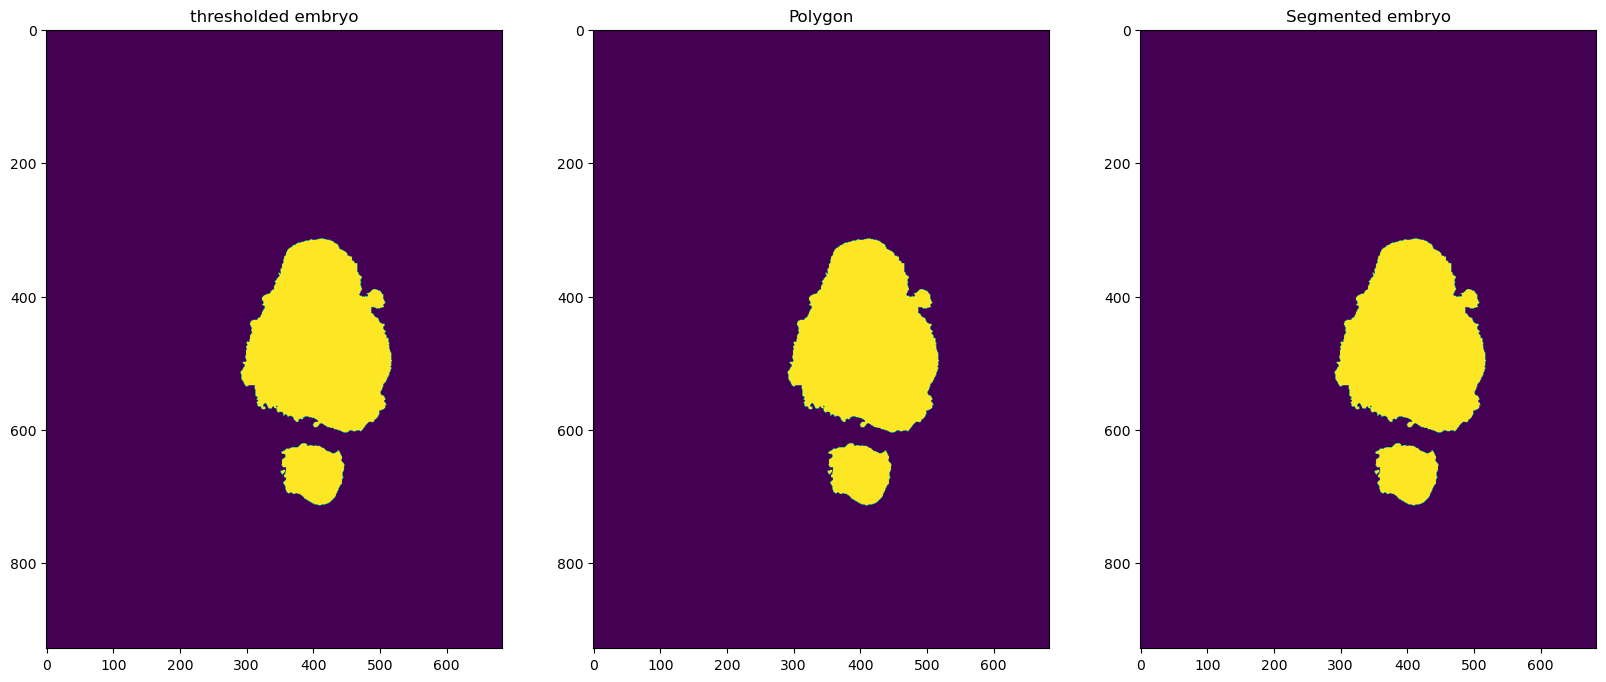

In [10]:

#Indicate timepoint to test
tmp = 16

#Get timepoint for thresholded embryo mask
embr_timepoint_mask = embryo_mask_timecourse[tmp, :, :]

#Get timepoint for PiP2-enriched domains mask
pip2_timepoint_mask = pip2_mask_timecourse[tmp, :, :]

#Get timepoint for cyk1-enriched domains mask
cyk1_timepoint_mask = cyk1_mask_timecourse[tmp, :, :]

#Get timepoint for arx2-enriched domains mask
arx2_timepoint_mask = arx2_mask_timecourse[tmp, :, :]



#Segment mask, if necessary - MAINTAIN SEGMENTED REGION
#======= THIS (polygon_vertices) IS THE VARIABLE TO CHANGE FOR TESTING THE POLYGON VERTICES
#Indicate a list of the polygon vertices in clock-wise order. Each vertex is indicated as [y_row, x_column] of the array. The start (the [0,0] coordinates) is top-left corner.
#If the entire image has to be kept, either leave an empty list (note: and empty list is this: [])
list_of_polygon_vertices = []
#======= THIS (polygon_vertices) IS THE VARIABLE TO CHANGE FOR TESTING THE POLYGON VERTICES


#Plot the result
fig1, ax1 = plt.subplots(1,3, figsize=(20,10))
ax1[0].set_title("thresholded embryo")
ax1[0].imshow(embr_timepoint_mask)

#Form the patch to segment the embryo if it is indicated
if len(list_of_polygon_vertices)!=0:
    #Display the segmentation result
    polygon_vertices = np.array(list_of_polygon_vertices)
    #Form a mask with the indicated vertices
    polygon_mask = polygon2mask(embr_timepoint_mask.shape, polygon_vertices)
    #Form a matplotlib patch, to visualize the result
    p_patch = plt.Polygon([[x[1], x[0]] for x in list(polygon_vertices)], fill=False, edgecolor='red', linewidth=1)
    #Segment the embryo, and visualize the result
    segmented_embr_timepoint = np.where(polygon_mask==True, embr_timepoint_mask, 0)
    ax1[0].add_patch(p_patch)
    ax1[1].set_title("Polygon")
    ax1[1].imshow(polygon_mask)
#Alternative just show the entire image
else:
    segmented_embr_timepoint = embr_timepoint_mask
    polygon_mask = embr_timepoint_mask
    
ax1[1].set_title("Polygon")
ax1[1].imshow(polygon_mask)
ax1[2].set_title("Segmented embryo")
ax1[2].imshow(segmented_embr_timepoint)



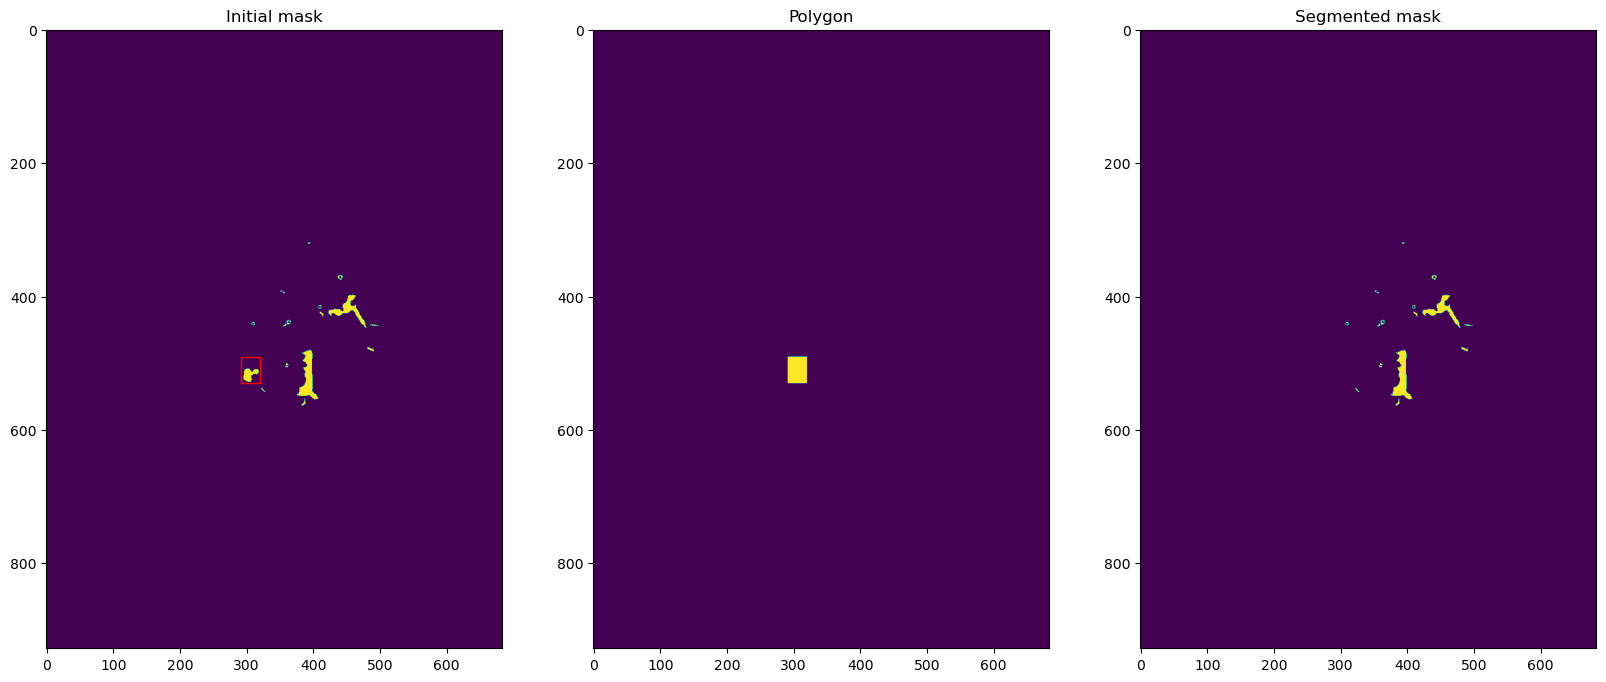

In [11]:

#Indicate timepoint to test
tmp = 29

#Get timepoint for thresholded embryo mask
embr_timepoint_mask = embryo_mask_timecourse[tmp, :, :]

#Get timepoint for PiP2-enriched domains mask
pip2_timepoint_mask = pip2_mask_timecourse[tmp, :, :]

#Get timepoint for cyk1-enriched domains mask
cyk1_timepoint_mask = cyk1_mask_timecourse[tmp, :, :]

#Get timepoint for arx2-enriched domains mask
arx2_timepoint_mask = arx2_mask_timecourse[tmp, :, :]

#=======
#STRUCTURE TO SEGMENT
structure_2_segment = pip2_timepoint_mask
# structure_2_segment = cyk1_timepoint_mask
#=======

#Segment mask, if necessary - EXCLUDE SEGMENTED REGION
#======= THIS (polygon_vertices) IS THE VARIABLE TO CHANGE FOR TESTING THE POLYGON VERTICES
#Indicate a list of the polygon vertices in clock-wise order. Each vertex is indicated as [y_row, x_column] of the array. The start (the [0,0] coordinates) is top-left corner.
#If the entire image has to be kept, either leave an empty list (note: and empty list is this: [])
polygon_vertices_list3 = [[491,292],[491,320], [530,320],[530,292]]
# ((491,292),(491,320), (530,320),(530,292))
#======= THIS (polygon_vertices) IS THE VARIABLE TO CHANGE FOR TESTING THE POLYGON VERTICES


#Plot the result
fig2, ax2 = plt.subplots(1,3, figsize=(20,10))
ax2[0].set_title("Initial mask")
ax2[0].imshow(structure_2_segment)

if len(polygon_vertices_list3)!=0:
    polygon_vertices3 = np.array(polygon_vertices_list3)
    #Display the segmentation result
    #Form a mask with the indicated vertices
    polygon_mask3 = polygon2mask(structure_2_segment.shape, polygon_vertices3)
    #Form a matplotlib patch, to visualize the result
    p_patch3 = plt.Polygon([[x3[1], x3[0]] for x3 in list(polygon_vertices3)], fill=False, edgecolor='red', linewidth=1)
    ax2[0].add_patch(p_patch3)
    #Segment the embryo, and visualize the result
    segmented___timepoint = np.where(polygon_mask3==True, 0, structure_2_segment)
else:
    polygon_mask3 = structure_2_segment
    segmented___timepoint = structure_2_segment
    
#Plot the result
ax2[1].set_title("Polygon")
ax2[1].imshow(polygon_mask3)
ax2[2].set_title("Segmented mask")
ax2[2].imshow(segmented___timepoint)



In [26]:
#ITERATE THROUGH THE TIMECOURSE - QUANTIFY THE RESULTS AND SAVE THEM


def preliminary_quantify_timecourse(p_embryo_mask_timecourse, p_pip2_mask_timecourse, p_cyk1_mask_timecourse, p_arx2_mask_timecourse, p_shuffle____times, p_saving_director_y, p_list_vrtx_main, p_list_vrtx_excl, p_segmentation_based_on_poly=None):
    if ((p_segmentation_based_on_poly != None) and (p_segmentation_based_on_poly != False)):
        if (len(p_list_vrtx_main) == 0) and (len(p_list_vrtx_excl) == 0):
            print("it is selected to segment the images, but no list of vertices is provided, plese indicate at least one of p_list_vrtx_main or p_list_vrtx_excl, or alternatively indicate p_segmentation_based_on_poly as False or remove it from the function")
            return
        else:
            quantify_timecourse(p_embryo_mask_timecourse, p_pip2_mask_timecourse, p_cyk1_mask_timecourse, p_arx2_mask_timecourse, p_shuffle____times, p_saving_director_y, True, p_list_vrtx_main, p_list_vrtx_excl)
    else:
        if (len(p_list_vrtx_main) != 0) or (len(p_list_vrtx_excl) != 0):
            print("WARNING: you did not specify to do a segmentation, but at least one of the p_list_vrtx_main, p_list_vrtx_excl lists contains some vertices. The function will proceed, but no segmentation will be done. To do the segmentation indicate p_segmentation_based_on_poly as True")
        quantify_timecourse(p_embryo_mask_timecourse, p_pip2_mask_timecourse, p_cyk1_mask_timecourse, p_arx2_mask_timecourse, p_shuffle____times, p_saving_director_y, False, p_list_vrtx_main, p_list_vrtx_excl)  


def quantify_timecourse(embryo_mask_i_timecourse, pip2_mask_i_timecourse, cyk1_mask_i_timecourse, arx2_mask_i_timecourse, shuffle____times, saving_director_y, segmentation_based_on_poly, list_vrtx_main, list_vrtx_excl):
    #If the polygon-based segmentation has to be done, indicate the vertices of the polygon to use and double-check that they are the ones which had been tested above
    if segmentation_based_on_poly:
        
        polygonal_segm_vertices_maintain = np.array(list_vrtx_main)
        polygonal_segm_vertices_tuple_maintain = tuple([(v[0],v[1]) for v in list_vrtx_main]) #transforming the vertices in a tuple of tuples is useful for adding it to the final dictionary
        polygonal_segm_vertices_exclude = np.array(list_vrtx_excl)
        polygonal_segm_vertices_tuple_exclude = tuple([(v2[0],v2[1]) for v2 in list_vrtx_excl]) #transforming the vertices in a tuple of tuples is useful for adding it to the final dictionary
        # polygonal_segm_vertices_tuple_glob = tuple([polygonal_segm_vertices_tuple_maintain, polygonal_segm_vertices_tuple_exclude]) #transforming the vertices in a tuple of tuples is useful for adding it to the final dictionary
        
        
    #Initialize a dictionary to be used for exporting the results
    results_dict = {"timepoint":[], "polygon_roi_segmentation":[], "yx_rrcc_vertices_pos_maintain":[], "yx_rrcc_vertices_pos_exclude":[],
                    "embryo_detect_pixels":[], "pip2_detect_pixels":[], "cyk1_detect_pixels":[],
                    "arx2_detect_pixels":[], "observed_pip2pos_of_cyk1pos":[], "observed_cyk1pos_of_pip2pos":[],
                    "observed_pip2pos_of_arx2pos":[], "observed_arx2pos_of_pip2pos":[], "observed_arx2pos_of_cyk1pos":[],
                    "observed_cyk1pos_of_arx2pos":[]}            

    #Add shuffle____times shuffle results
    for shffl_t in range(shuffle____times):
        shuffled_pip2pos_of_cyk1pos_n = "shuffled_pip2pos_of_cyk1pos_" + str(shffl_t)
        results_dict[shuffled_pip2pos_of_cyk1pos_n] = []

        shuffled_cyk1pos_of_pip2pos_n = "shuffled_cyk1pos_of_pip2pos_" + str(shffl_t)
        results_dict[shuffled_cyk1pos_of_pip2pos_n] = []

        shuffled_pip2pos_of_arx2pos_n = "shuffled_pip2pos_of_arx2pos_" + str(shffl_t)
        results_dict[shuffled_pip2pos_of_arx2pos_n] = []

        shuffled_arx2pos_of_pip2pos_n = "shuffled_arx2pos_of_pip2pos_" + str(shffl_t)
        results_dict[shuffled_arx2pos_of_pip2pos_n] = []

        shuffled_arx2pos_of_cyk1pos_n = "shuffled_arx2pos_of_cyk1pos_" + str(shffl_t)
        results_dict[shuffled_arx2pos_of_cyk1pos_n] = []

        shuffled_cyk1pos_of_arx2pos_n = "shuffled_cyk1pos_of_arx2pos_" + str(shffl_t)
        results_dict[shuffled_cyk1pos_of_arx2pos_n] = []
        
    
    #Initialize a timepoint counter
    tmpnt_c = 0
    
    #Iterate through the timepoints
    for t_mp in list(embryo_mask_i_timecourse):
        
        #Update results_dict with timepoint number, whether or not it will go through some polygon-based segmentation as well as the vertices of the polygon
        results_dict["timepoint"].append(tmpnt_c)
        results_dict["polygon_roi_segmentation"].append(segmentation_based_on_poly)

        #Initialize variables to define (later) which type of segmentation should be done
        maintain_segmentation = None
        exclude_segmentation = None
        
        if segmentation_based_on_poly:
            if len(polygonal_segm_vertices_tuple_maintain)>0:
                results_dict["yx_rrcc_vertices_pos_maintain"].append(polygonal_segm_vertices_tuple_maintain)
                #Set maintain_segmentation to True
                maintain_segmentation = True
            else:
                results_dict["yx_rrcc_vertices_pos_maintain"].append(np.NaN)
                #Set maintain_segmentation to False
                maintain_segmentation = False
            
            if len(polygonal_segm_vertices_tuple_exclude)>0:
                results_dict["yx_rrcc_vertices_pos_exclude"].append(polygonal_segm_vertices_tuple_exclude)
                #Set maintain_segmentation to True
                exclude_segmentation = True
            else:
                results_dict["yx_rrcc_vertices_pos_exclude"].append(np.NaN)
                #Set maintain_segmentation to True
                exclude_segmentation = False
        else:
            results_dict["yx_rrcc_vertices_pos_maintain"].append(np.NaN)
            results_dict["yx_rrcc_vertices_pos_exclude"].append(np.NaN)
        
        #Get timepoint for thresholded embryo mask
        embr_timep_mask = embryo_mask_i_timecourse[tmpnt_c, :, :]
        
        #Get timepoint for PiP2-enriched domains mask
        pip2_timep_mask = pip2_mask_i_timecourse[tmpnt_c, :, :]
        
        #Get timepoint for cyk1-enriched domains mask
        cyk1_timep_mask = cyk1_mask_i_timecourse[tmpnt_c, :, :]
        
        #Get timepoint for arx2-enriched domains mask
        arx2_timep_mask = arx2_mask_i_timecourse[tmpnt_c, :, :]
    
        #Segment all timepoints if a manual segmentation based on a polygonal roi is required
        if segmentation_based_on_poly:

            if ((maintain_segmentation == None) or (exclude_segmentation == None)):
                print("there hasn't been an update of the segmentations to carry on")
                return
                
            elif ((maintain_segmentation == True) and (exclude_segmentation == True)):
                #Form a mask with the indicated vertices for region to be maintained
                polygon_mas_k_maintain = polygon2mask(embr_timep_mask.shape, polygonal_segm_vertices_maintain)
        
                #Segment all timepoints masks
                segm_embr_timep_mask_maintain = np.where(polygon_mas_k_maintain==True, embr_timep_mask, 0)
                segm_pip2_timep_mask_maintain = np.where(polygon_mas_k_maintain==True, pip2_timep_mask, 0)
                segm_cyk1_timep_mask_maintain = np.where(polygon_mas_k_maintain==True, cyk1_timep_mask, 0)
                segm_arx2_timep_mask_maintain = np.where(polygon_mas_k_maintain==True, arx2_timep_mask, 0)
        
                #Form a mask with the indicated vertices for region to be excluded
                polygon_mas_k_exclude = polygon2mask(embr_timep_mask.shape, polygonal_segm_vertices_exclude)
        
                #Segment all timepoints masks
                segm_embr_timep_mask = np.where(polygon_mas_k_exclude==True, 0, segm_embr_timep_mask_maintain)
                segm_pip2_timep_mask = np.where(polygon_mas_k_exclude==True, 0, segm_pip2_timep_mask_maintain)
                segm_cyk1_timep_mask = np.where(polygon_mas_k_exclude==True, 0, segm_cyk1_timep_mask_maintain)
                segm_arx2_timep_mask = np.where(polygon_mas_k_exclude==True, 0, segm_arx2_timep_mask_maintain)
                
            elif ((maintain_segmentation == True) and (exclude_segmentation == False)):
                #Form a mask with the indicated vertices for region to be maintained
                polygon_mas__k_maintain = polygon2mask(embr_timep_mask.shape, polygonal_segm_vertices_maintain)
        
                #Segment all timepoints masks
                segm_embr_timep_mask = np.where(polygon_mas__k_maintain==True, embr_timep_mask, 0)
                segm_pip2_timep_mask = np.where(polygon_mas__k_maintain==True, pip2_timep_mask, 0)
                segm_cyk1_timep_mask = np.where(polygon_mas__k_maintain==True, cyk1_timep_mask, 0)
                segm_arx2_timep_mask = np.where(polygon_mas__k_maintain==True, arx2_timep_mask, 0)

            elif ((maintain_segmentation == False) and (exclude_segmentation == True)):
                #Form a mask with the indicated vertices for region to be excluded
                polygon_mas__k_exclude = polygon2mask(embr_timep_mask.shape, polygonal_segm_vertices_exclude)
        
                #Segment all timepoints masks
                segm_embr_timep_mask = np.where(polygon_mas__k_exclude==True, 0, embr_timep_mask)
                segm_pip2_timep_mask = np.where(polygon_mas__k_exclude==True, 0, pip2_timep_mask)
                segm_cyk1_timep_mask = np.where(polygon_mas__k_exclude==True, 0, cyk1_timep_mask)
                segm_arx2_timep_mask = np.where(polygon_mas__k_exclude==True, 0, arx2_timep_mask)
            
            else:
                print("something miscalculated")
        
        else:
            segm_embr_timep_mask = embr_timep_mask
            segm_pip2_timep_mask = pip2_timep_mask
            segm_cyk1_timep_mask = cyk1_timep_mask
            segm_arx2_timep_mask = arx2_timep_mask
        
        #Filter pip2, cyk1 and arx2 timepoint on the embryo mask
        fembr_segm_pip2_timep_mask = segm_pip2_timep_mask[segm_embr_timep_mask>0]
        fembr_segm_cyk1_timep_mask = segm_cyk1_timep_mask[segm_embr_timep_mask>0]
        fembr_segm_arx2_timep_mask = segm_arx2_timep_mask[segm_embr_timep_mask>0]

        #Update the results_dict with the area used for quantification (positive pixels in the embryo mask, after eventual polygonal segmentation)
        results_dict["embryo_detect_pixels"].append(fembr_segm_pip2_timep_mask.shape[0])
    
        #Count values in the filtered-segmented-masks, per each signal. NOTE: this step is done in order to avoid quantifying timepoints where the mask has no detected structure. Also note that the underlying assumption is that masks are binary arrays, where value 0 means "no structure passed the detection threshold" (aka there is no detected structure) while any positive value indicates a detected structure
        pip2_dict_val_counts, pip2_pos_val_check, pip2_pos_val_n = count_array_values_check_positive(fembr_segm_pip2_timep_mask)
        cyk1_dict_val_counts, cyk1_pos_val_check, cyk1_pos_val_n = count_array_values_check_positive(fembr_segm_cyk1_timep_mask)
        arx2_dict_val_counts, arx2_pos_val_check, arx2_pos_val_n = count_array_values_check_positive(fembr_segm_arx2_timep_mask)
        
        #Update the results_dict with the detected areas for pip2, cyk1 and ark2 -enriched domains masks
        results_dict["pip2_detect_pixels"].append(pip2_pos_val_n)
        results_dict["cyk1_detect_pixels"].append(cyk1_pos_val_n)
        results_dict["arx2_detect_pixels"].append(arx2_pos_val_n)
        
        #If there are positive detected structures for least 2 of the three structures, than shuffled arrays should be created, and I would like to create them the least amount of times
        if (pip2_pos_val_check==True and cyk1_pos_val_check==True) or (pip2_pos_val_check==True and arx2_pos_val_check==True) or (cyk1_pos_val_check==True and arx2_pos_val_check==True):
            
            #If some detected structures are present in the timepoint for both pip2-enriched domains and cyk1-enriched domains, quintify their relative overlap
            if (pip2_pos_val_check==True and cyk1_pos_val_check==True):
                
                #Quantify the fraction of cyk1-positive pixels which are also positive for pip2
                pip2positive_of_cyk1positive = measure_masks_overlap(fembr_segm_cyk1_timep_mask, fembr_segm_pip2_timep_mask)
                
                #Quantify the fraction of pip2-positive pixels which are also positive for cyk1
                cyk1positive_of_pip2positive = measure_masks_overlap(fembr_segm_pip2_timep_mask, fembr_segm_cyk1_timep_mask)
                
                #Add fractions to the results_dictionary
                results_dict["observed_pip2pos_of_cyk1pos"].append(pip2positive_of_cyk1positive)
                results_dict["observed_cyk1pos_of_pip2pos"].append(cyk1positive_of_pip2positive)
                
            #If no structure is detected in the timepoint for both pip2-enriched domains or cyk1-enriched domains, add an NaN to the results_dictionary
            else:
                
                results_dict["observed_pip2pos_of_cyk1pos"].append(np.NaN)
                results_dict["observed_cyk1pos_of_pip2pos"].append(np.NaN)
            
        
            #If some detected structures are present in the timepoint for both pip2-enriched domains and arx2-enriched domains, quintify their relative overlap
            if (pip2_pos_val_check==True and arx2_pos_val_check==True):
                
                #Quantify the fraction of arx2-positive pixels which are also positive for pip2
                pip2positive_of_arx2positive = measure_masks_overlap(fembr_segm_arx2_timep_mask, fembr_segm_pip2_timep_mask)
                
                #Quantify the fraction of pip2-positive pixels which are also positive for arx2
                arx2positive_of_pip2positive = measure_masks_overlap(fembr_segm_pip2_timep_mask, fembr_segm_arx2_timep_mask)
                
                #Add fractions to the results_dictionary
                results_dict["observed_pip2pos_of_arx2pos"].append(pip2positive_of_arx2positive)
                results_dict["observed_arx2pos_of_pip2pos"].append(arx2positive_of_pip2positive)
            
            #If no structure is detected in the timepoint for both pip2-enriched domains or arx2-enriched domains, add an NaN to the results_dictionary
            else:
                
                results_dict["observed_pip2pos_of_arx2pos"].append(np.NaN)
                results_dict["observed_arx2pos_of_pip2pos"].append(np.NaN)
            
            
            #If some detected structures are present in the timepoint for both cyk1-enriched domains and arx2-enriched domains, quintify their relative overlap
            if (cyk1_pos_val_check==True and arx2_pos_val_check==True):
                
                #Quantify the fraction of cyk1-positive pixels which are also positive for arx2
                arx2positive_of_cyk1positive = measure_masks_overlap(fembr_segm_cyk1_timep_mask, fembr_segm_arx2_timep_mask)
                
                #Quantify the fraction of arx2-positive pixels which are also positive for cyk1
                cyk1positive_of_arx2positive = measure_masks_overlap(fembr_segm_arx2_timep_mask, fembr_segm_cyk1_timep_mask)
                
                #Add fractions to the results_dictionary
                results_dict["observed_arx2pos_of_cyk1pos"].append(arx2positive_of_cyk1positive)
                results_dict["observed_cyk1pos_of_arx2pos"].append(cyk1positive_of_arx2positive)
                
            #If no structure is detected in the timepoint for both cyk1-enriched domains or arx2-enriched domains, add an NaN to the results_dictionary
            else:
                
                results_dict["observed_arx2pos_of_cyk1pos"].append(np.NaN)
                results_dict["observed_cyk1pos_of_arx2pos"].append(np.NaN)
            
            
            #Iterate through the number of shuffling times
            for shf in range(shuffle____times):

                #Re-form the names of the indeces of the result dictionary
                shuffled_pip2pos_of_cyk1pos_n_2 = "shuffled_pip2pos_of_cyk1pos_" + str(shf)
                shuffled_cyk1pos_of_pip2pos_n_2 = "shuffled_cyk1pos_of_pip2pos_" + str(shf)

                shuffled_pip2pos_of_arx2pos_n_2 = "shuffled_pip2pos_of_arx2pos_" + str(shf)
                shuffled_arx2pos_of_pip2pos_n_2 = "shuffled_arx2pos_of_pip2pos_" + str(shf)

                shuffled_arx2pos_of_cyk1pos_n_2 = "shuffled_arx2pos_of_cyk1pos_" + str(shf)
                shuffled_cyk1pos_of_arx2pos_n_2 = "shuffled_cyk1pos_of_arx2pos_" + str(shf)

                
                #Shuffle the arrays of the dirrefent channels. The output of the shuffling is a list - - NOTE: a slightly more efficient script version would generate the shuffled arrays only when required, but this would imply a lot of "if" statements, which would make the code hard to read and follow
                shff_pip2 = random.sample(list(fembr_segm_pip2_timep_mask), k=len(list(fembr_segm_pip2_timep_mask)))
                shff_cyk1 = random.sample(list(fembr_segm_cyk1_timep_mask), k=len(list(fembr_segm_cyk1_timep_mask)))
                shff_arx2 = random.sample(list(fembr_segm_arx2_timep_mask), k=len(list(fembr_segm_arx2_timep_mask)))
                
                
                #Transform shuffled lists into numpy arrays
                shuff_fembr_segm_pip2_timep_mask = np.asarray(shff_pip2)
                shuff_fembr_segm_cyk1_timep_mask = np.asarray(shff_cyk1)
                shuff_fembr_segm_arx2_timep_mask = np.asarray(shff_arx2)
                                
                #If some detected structures are present in the timepoint for both pip2-enriched domains and cyk1-enriched domains, quintify their relative overlap also for the shuffle
                if (pip2_pos_val_check==True and cyk1_pos_val_check==True):
                    #Quantify the fraction of cyk1-positive pixels which are also positive for pip2
                    shuff_pip2positive_of_cyk1positive = measure_masks_overlap(shuff_fembr_segm_cyk1_timep_mask, shuff_fembr_segm_pip2_timep_mask)
                    
                    #Quantify the fraction of pip2-positive pixels which are also positive for cyk1
                    shuff_cyk1positive_of_pip2positive = measure_masks_overlap(shuff_fembr_segm_pip2_timep_mask, shuff_fembr_segm_cyk1_timep_mask)

                    #Add the results to the respective columns of the collection dictionary
                    results_dict[shuffled_pip2pos_of_cyk1pos_n_2].append(shuff_pip2positive_of_cyk1positive)
                    results_dict[shuffled_cyk1pos_of_pip2pos_n_2].append(shuff_cyk1positive_of_pip2positive)
                else:
                    #Add NaN values to collection dictionary
                    results_dict[shuffled_pip2pos_of_cyk1pos_n_2].append(np.NaN)
                    results_dict[shuffled_cyk1pos_of_pip2pos_n_2].append(np.NaN)
                    
                    
                #If some detected structures are present in the timepoint for both pip2-enriched domains and arx2-enriched domains, quintify their relative overlap also for the shuffle
                if (pip2_pos_val_check==True and arx2_pos_val_check==True):
                    #Quantify the fraction of arx2-positive pixels which are also positive for pip2
                    shuff_pip2positive_of_arx2positive = measure_masks_overlap(shuff_fembr_segm_arx2_timep_mask, shuff_fembr_segm_pip2_timep_mask)
                    
                    #Quantify the fraction of pip2-positive pixels which are also positive for arx2
                    shuff_arx2positive_of_pip2positive = measure_masks_overlap(shuff_fembr_segm_pip2_timep_mask, shuff_fembr_segm_arx2_timep_mask)
                    
                    #Add the results to the respective columns of the collection dictionary
                    results_dict[shuffled_pip2pos_of_arx2pos_n_2].append(shuff_pip2positive_of_arx2positive)
                    results_dict[shuffled_arx2pos_of_pip2pos_n_2].append(shuff_arx2positive_of_pip2positive)
                else:
                    #Add NaN values to collection dictionary
                    results_dict[shuffled_pip2pos_of_arx2pos_n_2].append(np.NaN)
                    results_dict[shuffled_arx2pos_of_pip2pos_n_2].append(np.NaN)
                    
                
                #If some detected structures are present in the timepoint for both pip2-enriched domains and arx2-enriched domains, quintify their relative overlap also for the shuffle
                if (cyk1_pos_val_check==True and arx2_pos_val_check==True):
                    #Quantify the fraction of cyk1-positive pixels which are also positive for arx2
                    shuff_arx2positive_of_cyk1positive = measure_masks_overlap(shuff_fembr_segm_cyk1_timep_mask, shuff_fembr_segm_arx2_timep_mask)
                    
                    #Quantify the fraction of arx2-positive pixels which are also positive for cyk1
                    shuff_cyk1positive_of_arx2positive = measure_masks_overlap(shuff_fembr_segm_arx2_timep_mask, shuff_fembr_segm_cyk1_timep_mask)
                    
                    #Add the results to the respective columns of the collection dictionary
                    results_dict[shuffled_arx2pos_of_cyk1pos_n_2].append(shuff_arx2positive_of_cyk1positive)
                    results_dict[shuffled_cyk1pos_of_arx2pos_n_2].append(shuff_cyk1positive_of_arx2positive)
                else:
                    #Add the results to the respective columns of the collection dictionary
                    results_dict[shuffled_arx2pos_of_cyk1pos_n_2].append(np.NaN)
                    results_dict[shuffled_cyk1pos_of_arx2pos_n_2].append(np.NaN)
            
        
        #If there are no detected structures in two or more of the three channels, then there is no point in making the shuffling and the calculations. Thus just add NaN values to the collection dictionary used to create the output dataframe
        else:
            results_dict["observed_pip2pos_of_cyk1pos"].append(np.NaN)
            results_dict["observed_cyk1pos_of_pip2pos"].append(np.NaN)
            results_dict["observed_pip2pos_of_arx2pos"].append(np.NaN)
            results_dict["observed_arx2pos_of_pip2pos"].append(np.NaN)
            results_dict["observed_arx2pos_of_cyk1pos"].append(np.NaN)
            results_dict["observed_cyk1pos_of_arx2pos"].append(np.NaN)
            
            #Add NaN values for the shuffle results
            for shffld__t in range(shuffle____times):
                shuffled_pip2pos_of_cyk1pos_nn = "shuffled_pip2pos_of_cyk1pos_" + str(shffld__t)
                results_dict[shuffled_pip2pos_of_cyk1pos_nn].append(np.NaN)
        
                shuffled_cyk1pos_of_pip2pos_nn = "shuffled_cyk1pos_of_pip2pos_" + str(shffld__t)
                results_dict[shuffled_cyk1pos_of_pip2pos_nn].append(np.NaN)
        
                shuffled_pip2pos_of_arx2pos_nn = "shuffled_pip2pos_of_arx2pos_" + str(shffld__t)
                results_dict[shuffled_pip2pos_of_arx2pos_nn].append(np.NaN)
        
                shuffled_arx2pos_of_pip2pos_nn = "shuffled_arx2pos_of_pip2pos_" + str(shffld__t)
                results_dict[shuffled_arx2pos_of_pip2pos_nn].append(np.NaN)
        
                shuffled_arx2pos_of_cyk1pos_nn = "shuffled_arx2pos_of_cyk1pos_" + str(shffld__t)
                results_dict[shuffled_arx2pos_of_cyk1pos_nn].append(np.NaN)
        
                shuffled_cyk1pos_of_arx2pos_nn = "shuffled_cyk1pos_of_arx2pos_" + str(shffld__t)
                results_dict[shuffled_cyk1pos_of_arx2pos_nn].append(np.NaN)
        
        
        #Print the progress
        if tmpnt_c in [len(list(embryo_mask_i_timecourse))//8, len(list(embryo_mask_i_timecourse))//4, (len(list(embryo_mask_i_timecourse))//8)*3, len(list(embryo_mask_i_timecourse))//2, (len(list(embryo_mask_i_timecourse))//8)*5, (len(list(embryo_mask_i_timecourse))//4)*3, (len(list(embryo_mask_i_timecourse))//8)*7, len(list(embryo_mask_i_timecourse))]:
            print("="*3, tmpnt_c, "/",len(list(embryo_mask_i_timecourse)))
        
        #Update the timepoint counter
        tmpnt_c = tmpnt_c+1
    
    
    #Use the results_dict to form a dataframe
    results_df = pd.DataFrame.from_dict(results_dict)
    
    #Indicate the name of the results dataframe, for saving
    results_df_saving_name = "initial_quantification_results.csv"
    
    #Save the results
    results_df.to_csv(os.path.join(saving_director_y, results_df_saving_name), index=False)



#Indicate if the timecourse needs to be segmented using a polygonal roi - change the bottom parameter to True (if segmentation must be done) or False (if segmentation must not be done)
use_polygon_4segmentation = False

list_polygon_vertices_2maintain = []
list_polygon_vertices_2exclude = []

#Repeat the shuffle_times variable, to make sure it has been run
shuffle_times_rep = shuffle_times

#Use preliminary_quantify_timecourse function to quantify the timecourses
preliminary_quantify_timecourse(embryo_mask_timecourse, pip2_mask_timecourse, cyk1_mask_timecourse, arx2_mask_timecourse, shuffle_times_rep, output_folder, list_polygon_vertices_2maintain, list_polygon_vertices_2exclude, use_polygon_4segmentation)

print("wowowo")



=== 7 / 61
=== 15 / 61
=== 21 / 61
=== 30 / 61
=== 35 / 61
=== 45 / 61
=== 49 / 61
wowowo


In the following cells I import the results and add relevant columns for the analysis

In [27]:
#Indicate the path to the results dataframe
results_df_import_directory = os.path.join(output_folder, "initial_quantification_results.csv")

#Open the dataframe
imported_results_dtfrm = pd.read_csv(results_df_import_directory)
print(imported_results_dtfrm.columns)

def check_nopixels_have_nans(input_results_df_1, area_column):
    # Select rows where pip2 was not detected
    target_rows_df = input_results_df_1[input_results_df_1[area_column]==0]
    
    #Split the name of the area_column
    area_clm_split_name = area_column.split("_")

    #Initialize a collection list for columns with the target structure
    target_structure_l = []

    #Iterate through the columns
    for c in input_results_df_1.columns:
        #Don't include the area_columns, normalized area_columns and area ratio columns
        if area_column not in c:
            #If the target structure is in the name of the column, add it to the collection list
            if area_clm_split_name[0] in c:
                target_structure_l.append(c)
    
    #filter the dataframe for the target columns
    filtered_target_rows_df = target_rows_df[target_structure_l]
    
    #Count total number of non NaN values in the filtered dataframe
    total_non_nan = np.sum(filtered_target_rows_df.count())
    
    return total_non_nan


def double_check_results(input_results_df):
    
    # Check that columns with zero pixels for pip2 don't have any calculcation
    total_non_nan_pip2 = check_nopixels_have_nans(input_results_df, "pip2_detect_pixels")
    if total_non_nan_pip2>0:
        print("even though at least a timepoint has no pip2 detection, some measurements have been done")

    # Check that columns with zero pixels for cyk1 don't have any calculcation
    total_non_nan_cyk1 = check_nopixels_have_nans(input_results_df, "cyk1_detect_pixels")
    if total_non_nan_cyk1>0:
        print("even though at least a timepoint has no cyk1 detection, some measurements have been done")

    # Check that columns with zero pixels for arx2 don't have any calculcation
    total_non_nan_arx2 = check_nopixels_have_nans(input_results_df, "arx2_detect_pixels")
    if total_non_nan_arx2>0:
        print("even though at least a timepoint has no arx2 detection, some measurements have been done")


def add_normalized_columns__shuffle_mean_std(input__results__df):
    #Copy input dataframe not to mess it up
    input__results__df_copy = input__results__df.copy()

    #Initialize a dictionary linking the overlap measurements to their shuffle results
    overlap_to_shuffl_clms_d = {}
    
    #Iterate through the columns
    for clm in input__results__df_copy.columns:
        
        #Add a normalized column for the columns measuring the total area of the detected structures (idendified because their name contains '_detect_pixels')
        #And the columns measuring overlap between structures (identified by the presence of the string 'observed_' in the column)
        if ('_detect_pixels' in clm) or ('observed_' in clm): #Identify the columns with '_detect_pixels' string in the name
            normalized_clm_n = 'n_minmax_' + clm #Create the name of the new column containing the normalized values
            input__results__df_copy[normalized_clm_n] = (input__results__df_copy[clm] - input__results__df_copy[clm].min()) / (input__results__df_copy[clm].max() - input__results__df_copy[clm].min())

        #If the columns name contains "shuffle" find all the other shuffle columns with the same measurement
        elif 'shuffled_' in clm:

            #Get the part of the name of the column which tells what has been measured (simply identified by the string position)
            shuffle_measurement = clm[9:27]

            #Link the measurment name to the column name in the overlap_to_shuffl_clms_d dictionary
            if shuffle_measurement not in overlap_to_shuffl_clms_d:
                overlap_to_shuffl_clms_d[shuffle_measurement]=[clm]
            else:
                overlap_to_shuffl_clms_d[shuffle_measurement].append(clm)

    #Iterate through the measurements of overlap_to_shuffl_clms_d
    for msrmnt in overlap_to_shuffl_clms_d:

        #Add a column with the mean value and a column with the standard deviation of the shuffled variables
        shffld_mean_clm_n = 'shuffled_'+msrmnt+'_mean'
        shffld_stdv_clm_n = 'shuffled_'+msrmnt+'_stdv'
        input__results__df_copy[shffld_mean_clm_n] = input__results__df_copy[overlap_to_shuffl_clms_d[msrmnt]].mean(axis=1)
        input__results__df_copy[shffld_stdv_clm_n] = input__results__df_copy[overlap_to_shuffl_clms_d[msrmnt]].std(axis=1)
            
    return input__results__df_copy


def add_area_ratio_columns(input__pre_results__df, embryo_detected_pixels_clm_name):

    #Copy input__pre_results__df
    input__pre_results__df_copy = input__pre_results__df.copy()

    #Iterate through the columns of the copied input_df
    for c_lm in input__pre_results__df_copy.columns:
        #If the column name contains '_detect_pixels' then this is a meausurement of the area of different structures and I would like to calculate the ratio with the embryo.
        #Note that I only calculate it for columns which are not the embryo itself. I also avoid the normalized columns
        if (('_detect_pixels' in c_lm) and ('embryo' not in c_lm) and ('n_' not in c_lm)):
            #Create the name of the column of the ratio area/embryo_area
            embryo_ratio_clm_n = c_lm + "__ratio_of_embryo"
            #Add the column with the ratio between pip2, cyk1 and arx2 detected areas and the embryo detected area
            input__pre_results__df_copy[embryo_ratio_clm_n] = input__pre_results__df_copy[c_lm]/input__pre_results__df_copy[embryo_detected_pixels_clm_name]

    return input__pre_results__df_copy

        
#Use double_check_results function to double-check the the initial dataframe is created properly
double_check_results(imported_results_dtfrm)

#Use add_area_ratio_columns function to add the ratio between pip2, cyk1 and arx2 segmented structures, and the embryo segmentation
results_df_with_area_ratio = add_area_ratio_columns(imported_results_dtfrm, 'embryo_detect_pixels')
double_check_results(results_df_with_area_ratio)
# print(results_df_with_area_ratio.columns)

#Use add_normalized_columns function to add normalized columns and mean and standard deviation columns
wrangled_result_df = add_normalized_columns__shuffle_mean_std(results_df_with_area_ratio)
double_check_results(wrangled_result_df)

# print(wrangled_result_df.columns)


#Save the result
#Indicate the name of the results dataframe, for saving
new_results_df_saving_name = "quantification_results.csv"

#Save the results
wrangled_result_df.to_csv(os.path.join(output_folder, new_results_df_saving_name), index=False)


Index(['timepoint', 'polygon_roi_segmentation',
       'yx_rrcc_vertices_pos_maintain', 'yx_rrcc_vertices_pos_exclude',
       'embryo_detect_pixels', 'pip2_detect_pixels', 'cyk1_detect_pixels',
       'arx2_detect_pixels', 'observed_pip2pos_of_cyk1pos',
       'observed_cyk1pos_of_pip2pos', 'observed_pip2pos_of_arx2pos',
       'observed_arx2pos_of_pip2pos', 'observed_arx2pos_of_cyk1pos',
       'observed_cyk1pos_of_arx2pos', 'shuffled_pip2pos_of_cyk1pos_0',
       'shuffled_cyk1pos_of_pip2pos_0', 'shuffled_pip2pos_of_arx2pos_0',
       'shuffled_arx2pos_of_pip2pos_0', 'shuffled_arx2pos_of_cyk1pos_0',
       'shuffled_cyk1pos_of_arx2pos_0', 'shuffled_pip2pos_of_cyk1pos_1',
       'shuffled_cyk1pos_of_pip2pos_1', 'shuffled_pip2pos_of_arx2pos_1',
       'shuffled_arx2pos_of_pip2pos_1', 'shuffled_arx2pos_of_cyk1pos_1',
       'shuffled_cyk1pos_of_arx2pos_1', 'shuffled_pip2pos_of_cyk1pos_2',
       'shuffled_cyk1pos_of_pip2pos_2', 'shuffled_pip2pos_of_arx2pos_2',
       'shuffled_arx2pos_

In [49]:
#BATCH PROCESS
# root_input_directory = r"/Users/ulivia/Desktop/Alessandro/projects/filopodia_actin_dynamics_img/output_files_new"
root_input_directory = r"/Users/ulivia/Desktop/Alessandro/projects/filopodia_actin_dynamics_img/labelled_img"

#Iterate through the files of the root_input_directory, avoiding hidden files
for smpl_l in listdirNHF(root_input_directory):
    #If the file name contains "embryo_" then I should work on it
    if "embryo_" in smpl_l:
        #Extend root_directory to the embryo folder
        smpl_l_dir = os.path.join(root_input_directory, smpl_l)
        #Get the directory of the preliminary quantification file
        pre_quant_file_dir = os.path.join(smpl_l_dir, "initial_quantification_results.csv")
        #Open the preliminary quantification file
        pre_quant_file_df = pd.read_csv(pre_quant_file_dir)
        #Use double_check_results function to double-check the the initial dataframe is created properly
        double_check_results(pre_quant_file_df)
        
        #Use add_area_ratio_columns function to add the ratio between pip2, cyk1 and arx2 segmented structures, and the embryo segmentation
        pre_quant_file_df_with_area_ratio = add_area_ratio_columns(pre_quant_file_df, 'embryo_detect_pixels')
        double_check_results(pre_quant_file_df_with_area_ratio)
        
        #Use add_normalized_columns function to add normalized columns and mean and standard deviation columns
        wrangled_result_pre_quant_file_df_with_area_ratio = add_normalized_columns__shuffle_mean_std(pre_quant_file_df_with_area_ratio)
        double_check_results(wrangled_result_pre_quant_file_df_with_area_ratio)


        #Save the result
        #Indicate the name of the results dataframe, for saving
        new_results_df__saving__name = "quantification_results.csv"
        
        #Save the results
        wrangled_result_pre_quant_file_df_with_area_ratio.to_csv(os.path.join(smpl_l_dir, new_results_df__saving__name), index=False)


print("wowowo")


In the following cells I import the results and plot them - they are not anymore used

In [22]:

# #Indicate the path to the results dataframe
# results_df_import_path = os.path.join(output_folder, "quantification_results.csv")

# #Open the dataframe
# imported_results_df = pd.read_csv(results_df_import_path)

# print(imported_results_df)
# # print(imported_results_df.columns)
# # print(imported_results_df.loc[114, 'cyk1_detect_pixels'])
# # print(imported_results_df.loc[114, 'observed_cyk1pos_of_pip2pos'])



In [23]:

# def plot_overlap_timecourse(df_2_plot, observed_column, shuffle_mean_column, shuffle_stdv_column, title_of_plot=None, x_axis_label=None, y_axis_label=None, timpoints2skip=None, ax=None):
#     """
#     Plots error bars at each timepoint of both the observed overlap fraction and the shuffled overlap fraction. The observed fraction will be a single point, shuffle a proper errorbar
#     Inputs: df_2_plot is a pandas dataframe containg at least the columns of the values to plot and the 'timepoint' columns. observed_column is the name (string) of the column of the observed overlap which it has to be plotted.
#     shuffle_mean_column, shuffle_stdv_column are the names (strings) of the columns with the values corresponding respectively to the mean and standard deviation of the shuffled results which have to be plotted.
#     timpoints2skip is an optional parameter which allows to list a timepoints which will not be plotted (note that timepoint counting starts from zero).
#     title_of_plot, x_axis_label, y_axis_label are optional parameters (strings) for the title and axis labels of the plot.
#     NOTE: as clear from the description, this function is tightly associated to how quantification has been done above
#     """
#     if ax is None:
#         ax = plt.gca()

#     #Initialize a list to collect positions on the x axis
#     x_ax_ticks = []

#     #Initialize a position counter
#     position_c = 0

#     #Iterate through the index of the dataframe
#     for i in df_2_plot.index:

#         #Get timepoint
#         time_point = df_2_plot.loc[i, 'timepoint']

#         #If the timepoint has to be plotted
#         if ((timpoints2skip == None) or (time_point not in timpoints2skip)):
        
#             #Get observed value
#             observed_v = df_2_plot.loc[i, observed_column]
    
#             #Get shuffle mean value
#             shuffle_mean_v = df_2_plot.loc[i, shuffle_mean_column]
    
#             #Get shuffle stdv value
#             shuffle_stdv_v = df_2_plot.loc[i, shuffle_stdv_column]
            
#             #Plot shuffle mean and standard deviation
#             ax.errorbar(position_c, shuffle_mean_v, yerr=shuffle_stdv_v , marker='o', markerfacecolor='w', markeredgecolor='#B3B3B3', markeredgewidth=2, markersize=10, capsize=0.0, linestyle=":", linewidth=2, ecolor='#B3B3B3')

#             #Plot observed value
#             ax.errorbar(position_c, observed_v, marker='x', markeredgecolor='#0E4B5E', markersize=10)

            
#         #Add position to x_ax_ticks
#         x_ax_ticks.append(position_c)
        
#         #Update position counter
#         position_c = position_c+1

#     #Form x axis tick labels
#     x_axis_tick_labels = [str(xt) for xt in x_ax_ticks]

#     #Add x ticks and labels
#     ax.set_xticks(x_ax_ticks)
#     ax.set_xticklabels(x_axis_tick_labels, fontsize=10)

#     #Add y ticks and labels
#     y_ax_ticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
#     ax.set_yticks(y_ax_ticks)
#     ax.set_yticklabels([str(yt) for yt in y_ax_ticks], fontsize=30)

#     #If indicated add title
#     if title_of_plot != None:
#         ax.set_title(title_of_plot, fontsize=30)

#     #If indicated add x axis label
#     if x_axis_label != None:
#         ax.set_xlabel(x_axis_label, fontsize=25)

#     #If indicated add y axis label
#     if y_axis_label != None:
#         ax.set_ylabel(y_axis_label, fontsize=25)
    
# print("wowowo")


In [24]:
# #Indicate if some timepoints have to be skipped - NOTE THAT DIFFERENTLY FROM FIJI THE NUMBERATION STARTS FROM 0, THUS TO SKIP TIMEPOINT 100 YOU HAVE TO INDICATE 99
# timepoints_to_skip = []
# # timepoints_to_skip = [tm for tm in range(214, 221)]
# # timepoints_to_skip = [tm for tm in range(160, 184)]+[tm for tm in range(360, 362)]
# print(timepoints_to_skip)


In [25]:

# fig3, ax3 = plt.subplots(1,1, figsize=(20,10))
# plot_overlap_timecourse(imported_results_df, 'observed_pip2pos_of_cyk1pos', 'shuffled_pip2pos_of_cyk1pos_mean', 'shuffled_pip2pos_of_cyk1pos_stdv', 'Fraction of cyk1-enriched domains on pip2-enriched domains', 'timepoints', '(pip2+ cyk1+)/cyk1+ pixels number', timepoints_to_skip, ax3)

# save_name_3 = os.path.join(output_folder, "cyk1_on_pip2_fract.png")
# fig3.savefig(save_name_3, dpi=300)


In [26]:

# fig4, ax4 = plt.subplots(1,1, figsize=(20,10))
# plot_overlap_timecourse(imported_results_df, 'observed_pip2pos_of_arx2pos', 'shuffled_pip2pos_of_arx2pos_mean', 'shuffled_pip2pos_of_arx2pos_stdv', 'Fraction of arx2-enriched domains on pip2-enriched domains', 'timepoints', '(pip2+ arx2+)/arx2+ pixels number', timepoints_to_skip, ax4)

# save_name_4 = os.path.join(output_folder, "arx2_on_pip2_fract.png")
# fig4.savefig(save_name_4, dpi=300)



In [27]:

# def plot_overlap_timecourse_1(df_2_plot, observed_column, shuffle_mean_column, shuffle_stdv_column, title_of_plot=None, x_axis_label=None, y_axis_label=None, timpoints2skip=None, ax=None):
#     """
#     Plots error bars at each timepoint of both the observed overlap fraction and the shuffled overlap fraction. The observed fraction will be a single point, shuffle a proper errorbar
#     Inputs: df_2_plot is a pandas dataframe containg at least the columns of the values to plot and the 'timepoint' columns. observed_column is the name (string) of the column of the observed overlap which it has to be plotted.
#     shuffle_mean_column, shuffle_stdv_column are the names (strings) of the columns with the values corresponding respectively to the mean and standard deviation of the shuffled results which have to be plotted.
#     timpoints2skip is an optional parameter which allows to list a timepoints which will not be plotted (note that timepoint counting starts from zero).
#     title_of_plot, x_axis_label, y_axis_label are optional parameters (strings) for the title and axis labels of the plot.
#     NOTE: as clear from the description, this function is tightly associated to how quantification has been done above
#     """
#     if ax is None:
#         ax = plt.gca()

#     #Initialize a list to collect positions on the x axis
#     x_ax_ticks = []

#     #Initialize a position counter
#     position_c = 0

#     #Iterate through the index of the dataframe
#     for i in df_2_plot.index:

#         #Get timepoint
#         time_point = df_2_plot.loc[i, 'timepoint']

#         #If the timepoint has to be plotted
#         if ((timpoints2skip == None) or (time_point not in timpoints2skip)):
        
#             #Get observed value
#             observed_v = df_2_plot.loc[i, observed_column]
    
#             #Get shuffle mean value
#             shuffle_mean_v = df_2_plot.loc[i, shuffle_mean_column]
    
#             #Get shuffle stdv value
#             shuffle_stdv_v = df_2_plot.loc[i, shuffle_stdv_column]
            
#             #Plot observed value
#             ax.errorbar(position_c, observed_v, marker='x', markeredgecolor='#0E4B5E', markersize=10)

#             #Plot shuffle mean and standard deviation
#             ax.errorbar(position_c, shuffle_mean_v, yerr=shuffle_stdv_v , marker='o', markerfacecolor='w', markeredgecolor='#B3B3B3', markeredgewidth=2, markersize=10, capsize=0.0, linestyle=":", linewidth=2, ecolor='#B3B3B3')

#         #Add position to x_ax_ticks
#         x_ax_ticks.append(position_c)
        
#         #Update position counter
#         position_c = position_c+1

#     #Form x axis tick labels
#     x_axis_tick_labels = [str(xt) for xt in x_ax_ticks]

#     #Add x ticks and labels
#     ax.set_xticks(x_ax_ticks)
#     ax.set_xticklabels(x_axis_tick_labels, fontsize=10)

#     ax.set_ylim(-0.02, 0.1)
    
#     #Add y ticks and labels
#     y_ax_ticks = [0.0,0.025,0.05, 0.075, 0.1]
#     ax.set_yticks(y_ax_ticks)
#     ax.set_yticklabels([str(yt) for yt in y_ax_ticks], fontsize=30)
    
#     #If indicated add title
#     if title_of_plot != None:
#         ax.set_title(title_of_plot, fontsize=30)

#     #If indicated add x axis label
#     if x_axis_label != None:
#         ax.set_xlabel(x_axis_label, fontsize=25)

#     #If indicated add y axis label
#     if y_axis_label != None:
#         ax.set_ylabel(y_axis_label, fontsize=25)


# fig5, ax5 = plt.subplots(1,1, figsize=(20,10))
# plot_overlap_timecourse_1(imported_results_df, 'observed_cyk1pos_of_pip2pos', 'shuffled_cyk1pos_of_pip2pos_mean', 'shuffled_cyk1pos_of_pip2pos_stdv', 'Fraction of pip2-enriched domains on cyk1-enriched domains', 'timepoints', '(cyk1+ pip2+)/pip2+ pixels number', timepoints_to_skip, ax5)
# # plot_overlap_timecourse(imported_results_df, 'observed_cyk1pos_of_pip2pos', 'shuffled_cyk1pos_of_pip2pos_mean', 'shuffled_cyk1pos_of_pip2pos_stdv', 'Fraction of pip2-enriched domains on cyk1-enriched domains', 'timepoints', '(cyk1+ pip2+)/pip2+ pixels number', timepoints_to_skip, ax5)

# # save_name_5 = os.path.join(output_folder, "pip2_on_cyk1_fract.png")
# # fig5.savefig(save_name_5, dpi=300)


In [28]:

# fig6, ax6 = plt.subplots(1,1, figsize=(20,10))
# plot_overlap_timecourse(imported_results_df, 'observed_arx2pos_of_pip2pos', 'shuffled_arx2pos_of_pip2pos_mean', 'shuffled_arx2pos_of_pip2pos_stdv', 'Fraction of pip2-enriched domains on arx2-enriched domains', 'timepoints', '(arx2+ pip2+)/pip2+ pixels number', timepoints_to_skip, ax6)

# # save_name_6 = os.path.join(output_folder, "pip2_on_arx2_fract.png")
# # fig6.savefig(save_name_6, dpi=300)


In [29]:

# fig7, ax7 = plt.subplots(1,1, figsize=(20,10))
# plot_overlap_timecourse(imported_results_df, 'observed_arx2pos_of_cyk1pos', 'shuffled_arx2pos_of_cyk1pos_mean', 'shuffled_arx2pos_of_cyk1pos_stdv', 'Fraction of cyk1-enriched domains on arx2-enriched domains', 'timepoints', '(arx2+ cyk1+)/cyk1+ pixels number', timepoints_to_skip, ax7)

# save_name_7 = os.path.join(output_folder, "cyk1_on_arx2_fract.png")
# fig7.savefig(save_name_7, dpi=300)


In [30]:

# def plot_overlap_timecourse_2(df_2_plot, observed_column, shuffle_mean_column, shuffle_stdv_column, title_of_plot=None, x_axis_label=None, y_axis_label=None, timpoints2skip=None, ax=None):
#     """
#     Plots error bars at each timepoint of both the observed overlap fraction and the shuffled overlap fraction. The observed fraction will be a single point, shuffle a proper errorbar
#     Inputs: df_2_plot is a pandas dataframe containg at least the columns of the values to plot and the 'timepoint' columns. observed_column is the name (string) of the column of the observed overlap which it has to be plotted.
#     shuffle_mean_column, shuffle_stdv_column are the names (strings) of the columns with the values corresponding respectively to the mean and standard deviation of the shuffled results which have to be plotted.
#     timpoints2skip is an optional parameter which allows to list a timepoints which will not be plotted (note that timepoint counting starts from zero).
#     title_of_plot, x_axis_label, y_axis_label are optional parameters (strings) for the title and axis labels of the plot.
#     NOTE: as clear from the description, this function is tightly associated to how quantification has been done above
#     """
#     if ax is None:
#         ax = plt.gca()

#     #Initialize a list to collect positions on the x axis
#     x_ax_ticks = []

#     #Initialize a position counter
#     position_c = 0

#     #Iterate through the index of the dataframe
#     for i in df_2_plot.index:

#         #Get timepoint
#         time_point = df_2_plot.loc[i, 'timepoint']

#         #If the timepoint has to be plotted
#         if ((timpoints2skip == None) or (time_point not in timpoints2skip)):
        
#             #Get observed value
#             observed_v = df_2_plot.loc[i, observed_column]
    
#             #Get shuffle mean value
#             shuffle_mean_v = df_2_plot.loc[i, shuffle_mean_column]
    
#             #Get shuffle stdv value
#             shuffle_stdv_v = df_2_plot.loc[i, shuffle_stdv_column]
            
#             #Plot observed value
#             ax.errorbar(position_c, observed_v, marker='x', markeredgecolor='#0E4B5E', markersize=10)

#             #Plot shuffle mean and standard deviation
#             ax.errorbar(position_c, shuffle_mean_v, yerr=shuffle_stdv_v , marker='o', markerfacecolor='w', markeredgecolor='#B3B3B3', markeredgewidth=2, markersize=10, capsize=0.0, linestyle=":", linewidth=2, ecolor='#B3B3B3')

#         #Add position to x_ax_ticks
#         x_ax_ticks.append(position_c)
        
#         #Update position counter
#         position_c = position_c+1

#     #Form x axis tick labels
#     x_axis_tick_labels = [str(xt) for xt in x_ax_ticks]

#     #Add x ticks and labels
#     ax.set_xticks(x_ax_ticks)
#     ax.set_xticklabels(x_axis_tick_labels, fontsize=10)

#     ax.set_ylim(-0.02, 0.1)
    
#     #Add y ticks and labels
#     y_ax_ticks = [0.0, 0.05, 0.1]
#     ax.set_yticks(y_ax_ticks)
#     ax.set_yticklabels([str(yt) for yt in y_ax_ticks], fontsize=30)
    
#     #If indicated add title
#     if title_of_plot != None:
#         ax.set_title(title_of_plot, fontsize=30)

#     #If indicated add x axis label
#     if x_axis_label != None:
#         ax.set_xlabel(x_axis_label, fontsize=25)

#     #If indicated add y axis label
#     if y_axis_label != None:
#         ax.set_ylabel(y_axis_label, fontsize=25)


# fig8, ax8 = plt.subplots(1,1, figsize=(20,10))
# plot_overlap_timecourse_2(imported_results_df, 'observed_cyk1pos_of_arx2pos', 'shuffled_cyk1pos_of_arx2pos_mean', 'shuffled_cyk1pos_of_arx2pos_stdv', 'Fraction of arx2-enriched domains on cyk1-enriched domains', 'timepoints', '(cyk1+ arx2+)/arx2+ pixels number', timepoints_to_skip, ax8)
# # plot_overlap_timecourse(imported_results_df, 'observed_cyk1pos_of_arx2pos', 'shuffled_cyk1pos_of_arx2pos_mean', 'shuffled_cyk1pos_of_arx2pos_stdv', 'Fraction of arx2-enriched domains on cyk1-enriched domains', 'timepoints', '(cyk1+ arx2+)/arx2+ pixels number', timepoints_to_skip, ax8)

# # save_name_8 = os.path.join(output_folder, "arx2_on_cyk1_fract.png")
# # fig8.savefig(save_name_8, dpi=300)



In [31]:

# def plot_quantif_area_timecourse(df_2_plot, area_column, title_of_plot=None, x_axis_label=None, y_axis_label=None, timpoints2skip=None, ax=None):
#     """
#     Plots error bars at each timepoint of both the observed overlap fraction and the shuffled overlap fraction. The observed fraction will be a single point, shuffle a proper errorbar
#     Inputs: df_2_plot is a pandas dataframe containg at least the columns of the values to plot and the 'timepoint' columns. observed_column is the name (string) of the column of the observed overlap which it has to be plotted.
#     shuffle_mean_column, shuffle_stdv_column are the names (strings) of the columns with the values corresponding respectively to the mean and standard deviation of the shuffled results which have to be plotted.
#     timpoints2skip is an optional parameter which allows to list a timepoints which will not be plotted (note that timepoint counting starts from zero).
#     title_of_plot, x_axis_label, y_axis_label are optional parameters (strings) for the title and axis labels of the plot.
#     NOTE: as clear from the description, this function is tightly associated to how quantification has been done above
#     """
#     if ax is None:
#         ax = plt.gca()

#     #Initialize a list to collect positions on the x axis
#     x_ax_ticks = []

#     #Initialize a position counter
#     position_c = 0

#     #Iterate through the index of the dataframe
#     for i in df_2_plot.index:

#         #Get timepoint
#         time_point = df_2_plot.loc[i, 'timepoint']

#         #If the timepoint has to be plotted
#         if ((timpoints2skip == None) or (time_point not in timpoints2skip)):
        
#             #Get observed value
#             observed_area = df_2_plot.loc[i, area_column]
            
#             #Plot observed value
#             ax.errorbar(position_c, observed_area, marker='x', markeredgecolor='#0E4B5E', markersize=10)
            
#         #Add position to x_ax_ticks
#         x_ax_ticks.append(position_c)
        
#         #Update position counter
#         position_c = position_c+1

#     #Form x axis tick labels
#     x_axis_tick_labels = [str(xt) for xt in x_ax_ticks]

#     ax.tick_params(axis='y',labelsize=20)
    
#     #Add x ticks and labels
#     ax.set_xticks(x_ax_ticks)
#     ax.set_xticklabels(x_axis_tick_labels, fontsize=10)
#     # ax.set_xticklabels(x_axis_tick_labels)

#     # ax.set_ylim(-0.001, 0.1)
    
#     # #Add y ticks and labels
#     # y_ax_ticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
#     # ax.set_yticks(y_ax_ticks)
#     # ax.set_yticklabels([str(yt) for yt in y_ax_ticks], fontsize=30)
    
#     #If indicated add title
#     if title_of_plot != None:
#         ax.set_title(title_of_plot, fontsize=30)

#     #If indicated add x axis label
#     if x_axis_label != None:
#         ax.set_xlabel(x_axis_label, fontsize=25)

#     #If indicated add y axis label
#     if y_axis_label != None:
#         ax.set_ylabel(y_axis_label, fontsize=25)


# fig9, ax9 = plt.subplots(1,1, figsize=(20,10))
# plot_quantif_area_timecourse(imported_results_df, 'embryo_detect_pixels', 'Segmented embryo area', 'timepoints', 'Area (n of pixels)', timepoints_to_skip, ax9)

# save_name_9 = os.path.join(output_folder, "segmented_embryo_area.png")
# fig9.savefig(save_name_9, dpi=300)



In [32]:

# fig10, ax10 = plt.subplots(1,1, figsize=(20,10))
# plot_quantif_area_timecourse(imported_results_df, 'pip2_detect_pixels', 'Segmented pip2 area', 'timepoints', 'Area (n of pixels)', timepoints_to_skip, ax10)

# save_name_10 = os.path.join(output_folder, "segmented_pip2_area.png")
# fig10.savefig(save_name_10, dpi=300)


In [33]:

# fig11, ax11 = plt.subplots(1,1, figsize=(20,10))
# plot_quantif_area_timecourse(imported_results_df, 'cyk1_detect_pixels', 'Segmented cyk1 area', 'timepoints', 'Area (n of pixels)', timepoints_to_skip, ax11)

# save_name_11 = os.path.join(output_folder, "segmented_cyk1_area.png")
# fig11.savefig(save_name_11, dpi=300)


In [34]:

# fig12, ax12 = plt.subplots(1,1, figsize=(20,10))
# plot_quantif_area_timecourse(imported_results_df, 'arx2_detect_pixels', 'Segmented arx2 area', 'timepoints', 'Area (n of pixels)', timepoints_to_skip, ax12)

# save_name_12 = os.path.join(output_folder, "segmented_arx2_area.png")
# fig12.savefig(save_name_12, dpi=300)
